In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
from pdpbox import pdp, get_dataset, info_plots
from matplotlib.pyplot import MultipleLocator

plt.style.use('ggplot')

In [102]:
# Import data
data = pd.read_csv('../DS_Challenges/Employee_Retention/employee_retention.csv')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


## Create a table with 3 columns: day, employee_headcount, company_id

In [103]:
# change from str to datetime
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [104]:
# Get unique company ids
company = data['company_id'].value_counts().reset_index().sort_values('index')['index'].to_list()
# Get each day in the time range
t_range = pd.date_range('2011-01-24','2015-12-13') 

In [105]:
# Initialize headcount
headcount = {}
for t in t_range:
    headcount[t] = [0 for i in range(len(company))]

today = pd.to_datetime('2015-12-13')

In [31]:
%%time
# Calculate headcount for each company in each day
for i in range(24702):
    start = data.iloc[i,5]
    end = data.iloc[i,6]
    c_id = data.iloc[i,1]
    for c in company:
        if c_id == c:
            if pd.isnull(end):
                for t in pd.date_range(start,today):
                    headcount[t][c-1] = headcount[t][c-1]+1
            else:
                for t in pd.date_range(start,end):
                    headcount[t][c-1] = headcount[t][c-1]+1

CPU times: user 23.2 s, sys: 181 ms, total: 23.4 s
Wall time: 23.3 s


In [35]:
# change dict to list
my_list = []
for day in t_range:
    for c in company:
        my_list.append([day,headcount[day][c-1],c])

In [38]:
my_list

[[Timestamp('2011-01-24 00:00:00', freq='D'), 25, 1],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 17, 2],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 9, 3],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 12, 4],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 5, 5],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 3, 6],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 1, 7],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 6, 8],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 3, 9],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 0, 10],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 0, 11],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 0, 12],
 [Timestamp('2011-01-25 00:00:00', freq='D'), 27, 1],
 [Timestamp('2011-01-25 00:00:00', freq='D'), 19, 2],
 [Timestamp('2011-01-25 00:00:00', freq='D'), 10, 3],
 [Timestamp('2011-01-25 00:00:00', freq='D'), 12, 4],
 [Timestamp('2011-01-25 00:00:00', freq='D'), 5, 5],
 [Timestamp('2011-01-25 00:00:00', freq='D'), 3, 6],
 [Timestamp('2011-01-25 00:00:00', f

In [43]:
# change list to df
df = pd.DataFrame(data = my_list, columns = ['Day','Headcount','CompanyId'])
df

,Day,Headcount,CompanyId
0,2011-01-24,25,1
1,2011-01-24,17,2
2,2011-01-24,9,3
3,2011-01-24,12,4
4,2011-01-24,5,5
...,...,...,...
21415,2015-12-13,468,8
21416,2015-12-13,432,9
21417,2015-12-13,385,10
21418,2015-12-13,4,11


Now we have a dateframe which records the headcount in each day of each company

## What are the main factors that drive employee churn? Do they make sense?
Explain your findings.

<AxesSubplot:xlabel='Day', ylabel='Headcount'>

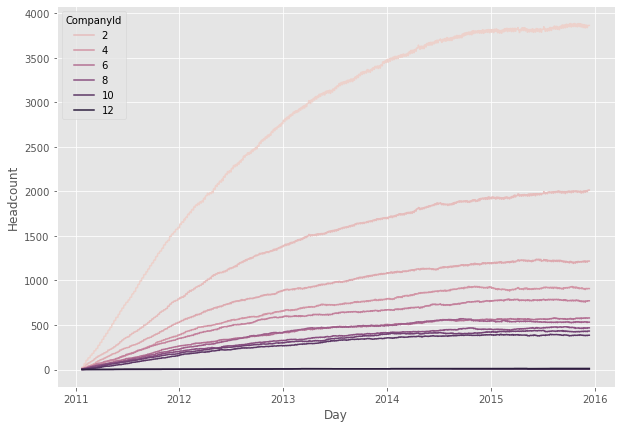

In [52]:
plt.figure(figsize = (10,7))
sns.lineplot(data = df, x = 'Day', y = 'Headcount', hue = 'CompanyId')

In [57]:
# Headcount of each company in the last day
df.loc[df['Day'] == pd.to_datetime('2015-12-13')].sort_values(by = 'Headcount', ascending = False)

,Day,Headcount,CompanyId
21408,2015-12-13,3865,1
21409,2015-12-13,2016,2
21410,2015-12-13,1218,3
21411,2015-12-13,909,4
21412,2015-12-13,772,5
21413,2015-12-13,579,6
21414,2015-12-13,532,7
21415,2015-12-13,468,8
21416,2015-12-13,432,9
21417,2015-12-13,385,10


In [106]:
data['company_id'] = [str(i) for i in data['company_id']]
quit = data.loc[~data['quit_date'].isnull()]
non_quit = data.loc[data['quit_date'].isnull()]

In [107]:
quit.describe()

,employee_id,seniority,salary
count,13510.000000,13510.000000,13510.000000
mean,502039.463138,14.131458,135652.405625
std,287981.253645,8.008437,71443.847770
min,36.000000,1.000000,17000.000000
25%,252829.500000,7.000000,81000.000000
50%,501207.500000,14.000000,122000.000000
75%,755069.250000,21.000000,180000.000000
max,999969.000000,99.000000,379000.000000


In [108]:
non_quit.describe()

,employee_id,seniority,salary
count,11192.000000,11192.000000,11192.000000
mean,501079.237759,14.123392,141238.473910
std,290037.003838,8.186682,81178.192226
min,107.000000,1.000000,17000.000000
25%,247897.000000,7.000000,76000.000000
50%,499790.000000,14.000000,123000.000000
75%,750487.000000,21.000000,195000.000000
max,999840.000000,29.000000,408000.000000


In [109]:
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09


In [74]:
quit['dept'].value_counts()

customer_service    5094
engineer            2362
sales               1811
marketing           1783
data_science        1682
design               778
Name: dept, dtype: int64

In [75]:
non_quit['dept'].value_counts()

customer_service    4086
engineer            2251
data_science        1508
marketing           1384
sales               1361
design               602
Name: dept, dtype: int64

## EDA

In [110]:
data['quit'] = [1 if pd.isnull(i) else 0 for i in data['quit_date']]

In [111]:
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,1
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0
...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT,1
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT,1
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,0
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,0


In [112]:
data = pd.get_dummies(data)
data

,employee_id,seniority,salary,join_date,quit_date,quit,company_id_1,company_id_10,company_id_11,company_id_12,...,company_id_6,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,13021.0,28,89000.0,2014-03-24,2015-10-30,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,825355.0,20,183000.0,2013-04-29,2014-04-04,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,927315.0,14,101000.0,2014-10-13,NaT,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,662910.0,20,115000.0,2012-05-14,2013-06-07,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,256971.0,23,276000.0,2011-10-17,2014-08-22,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697,549847.0,16,97000.0,2015-02-18,NaT,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24698,590087.0,10,160000.0,2015-10-26,NaT,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24699,777612.0,11,67000.0,2013-09-03,2015-10-23,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24700,97289.0,98,266000.0,2011-12-13,2015-01-09,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [113]:
data['seniority'] = (data['seniority']-data['seniority'].mean())/data['seniority'].std()
data['salary'] = (data['salary'] -data['salary'].mean())/data['salary'].std()
data

,employee_id,seniority,salary,join_date,quit_date,quit,company_id_1,company_id_10,company_id_11,company_id_12,...,company_id_6,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,13021.0,1.714836,-0.646654,2014-03-24,2015-10-30,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,825355.0,0.725902,0.589242,2013-04-29,2014-04-04,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,927315.0,-0.015799,-0.488880,2014-10-13,NaT,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,662910.0,0.725902,-0.304811,2012-05-14,2013-06-07,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,256971.0,1.096752,1.811990,2011-10-17,2014-08-22,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697,549847.0,0.231435,-0.541472,2015-02-18,NaT,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24698,590087.0,-0.510266,0.286842,2015-10-26,NaT,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24699,777612.0,-0.386649,-0.935906,2013-09-03,2015-10-23,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24700,97289.0,10.368007,1.680512,2011-12-13,2015-01-09,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [144]:
length = []
for i in range(len(data['employee_id'])):
    if pd.isnull(data.iloc[i,4]):
        length.append(today - data.iloc[i,3])
    else:
        length.append(data.iloc[i,4]-data.iloc[i,3])

In [145]:
length

[Timedelta('585 days 00:00:00'),
 Timedelta('340 days 00:00:00'),
 Timedelta('426 days 00:00:00'),
 Timedelta('389 days 00:00:00'),
 Timedelta('1040 days 00:00:00'),
 Timedelta('578 days 00:00:00'),
 Timedelta('783 days 00:00:00'),
 Timedelta('648 days 00:00:00'),
 Timedelta('1047 days 00:00:00'),
 Timedelta('1279 days 00:00:00'),
 Timedelta('837 days 00:00:00'),
 Timedelta('216 days 00:00:00'),
 Timedelta('340 days 00:00:00'),
 Timedelta('1194 days 00:00:00'),
 Timedelta('340 days 00:00:00'),
 Timedelta('409 days 00:00:00'),
 Timedelta('723 days 00:00:00'),
 Timedelta('622 days 00:00:00'),
 Timedelta('349 days 00:00:00'),
 Timedelta('139 days 00:00:00'),
 Timedelta('55 days 00:00:00'),
 Timedelta('340 days 00:00:00'),
 Timedelta('1316 days 00:00:00'),
 Timedelta('360 days 00:00:00'),
 Timedelta('368 days 00:00:00'),
 Timedelta('619 days 00:00:00'),
 Timedelta('839 days 00:00:00'),
 Timedelta('347 days 00:00:00'),
 Timedelta('795 days 00:00:00'),
 Timedelta('1152 days 00:00:00'),
 Time

In [146]:
data['length'] = [i for i in length]
data

,employee_id,seniority,salary,join_date,quit_date,quit,company_id_1,company_id_10,company_id_11,company_id_12,...,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,length
0,13021.0,1.714836,-0.646654,2014-03-24,2015-10-30,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,585 days
1,825355.0,0.725902,0.589242,2013-04-29,2014-04-04,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,340 days
2,927315.0,-0.015799,-0.488880,2014-10-13,NaT,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,426 days
3,662910.0,0.725902,-0.304811,2012-05-14,2013-06-07,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,389 days
4,256971.0,1.096752,1.811990,2011-10-17,2014-08-22,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1040 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697,549847.0,0.231435,-0.541472,2015-02-18,NaT,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,298 days
24698,590087.0,-0.510266,0.286842,2015-10-26,NaT,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48 days
24699,777612.0,-0.386649,-0.935906,2013-09-03,2015-10-23,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,780 days
24700,97289.0,10.368007,1.680512,2011-12-13,2015-01-09,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1123 days


In [170]:
data['length'] = data['length'].astype("str").str.split().str[0].astype('int')
data

,employee_id,seniority,salary,join_date,quit_date,quit,company_id_1,company_id_10,company_id_11,company_id_12,...,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,length
7271,550720.0,-1.499199,-1.553854,2015-12-03,NaT,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,10
4376,749254.0,0.849519,2.337903,2015-12-03,NaT,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,10
8661,315613.0,1.714836,2.114390,2015-12-03,NaT,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,10
20479,422569.0,-1.128349,0.484059,2015-12-03,NaT,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,10
7300,103167.0,-0.263032,-0.528324,2013-03-18,NaT,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19325,158786.0,-1.499199,-1.422376,2011-09-12,2014-06-06,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,998
6019,153096.0,-0.757499,-0.870167,2011-12-19,2014-09-12,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,998
6942,907455.0,0.849519,0.484059,2011-05-23,2014-02-14,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,998
4194,854669.0,0.478668,-0.423141,2013-03-19,NaT,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,999


In [174]:
data = data.sort_values('length')
data

,employee_id,seniority,salary,join_date,quit_date,quit,company_id_1,company_id_10,company_id_11,company_id_12,...,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,length
14533,957941.0,-0.263032,0.865346,2015-12-10,NaT,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,3
16467,928116.0,0.478668,0.247398,2015-12-10,NaT,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3
24611,815645.0,-1.375583,-1.067385,2015-12-09,NaT,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
8620,821435.0,0.973135,2.548268,2015-12-09,NaT,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
4128,890357.0,-1.622816,-1.382933,2015-12-09,NaT,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14351,592117.0,-0.263032,-0.988498,2011-02-07,NaT,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1770
8832,478641.0,0.478668,-0.462585,2011-02-07,NaT,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1770
1261,710287.0,-0.263032,-0.488880,2011-01-31,NaT,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1777
20930,582568.0,-0.881116,-0.055002,2011-01-31,NaT,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1777


<AxesSubplot:xlabel='length'>

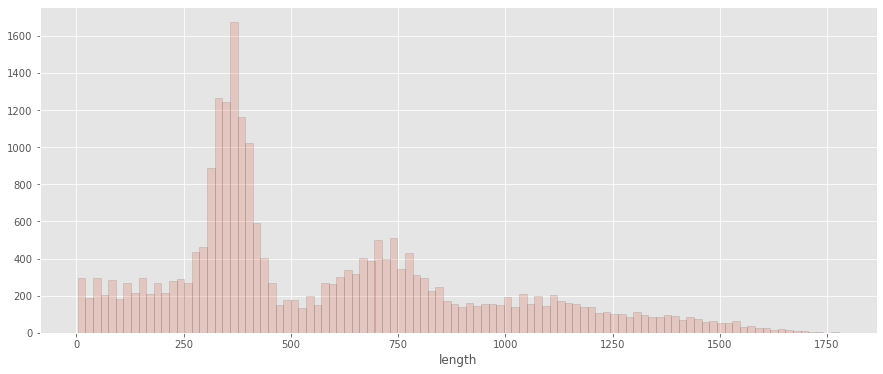

In [194]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(data['length'], bins=100, kde=False, ax=ax, hist_kws=hist_kws)


As we can see above that people tend to churn when they worked for around a year.

In [188]:
data['churn_week'] = data['quit_date'].dt.week
data.sample(10)

,employee_id,seniority,salary,join_date,quit_date,quit,company_id_1,company_id_10,company_id_11,company_id_12,...,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,length,churn_week
23043,594516.0,0.602285,2.009207,2011-04-27,NaT,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1691,NaN
21553,178376.0,0.231435,0.891642,2012-05-14,2013-05-03,0,1,0,0,0,...,0,0,0,0,0,0,1,0,354,18.0
13511,7744.0,-0.881116,-1.054237,2014-01-21,NaT,1,0,1,0,0,...,0,0,1,0,0,0,0,0,691,NaN
18856,931584.0,-0.881116,-0.883315,2015-06-29,NaT,1,1,0,0,0,...,0,0,1,0,0,0,0,0,167,NaN
12340,8466.0,-1.499199,-0.791280,2011-05-02,2014-03-07,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1040,10.0
4120,971017.0,0.973135,-0.594063,2015-05-18,NaT,1,0,0,0,0,...,0,0,1,0,0,0,0,0,209,NaN
2106,971864.0,1.591219,2.745486,2015-10-21,NaT,1,0,0,0,0,...,0,0,0,1,0,0,0,0,53,NaN
13390,889892.0,-0.386649,-0.935906,2012-02-21,2014-02-28,0,1,0,0,0,...,0,0,1,0,0,0,0,0,738,9.0
9081,104347.0,1.591219,1.601625,2013-01-15,2013-12-13,0,1,0,0,0,...,0,0,0,1,0,0,0,0,332,50.0
6385,984437.0,-0.757499,-1.014793,2015-06-01,NaT,1,0,0,0,0,...,0,0,1,0,0,0,0,0,195,NaN


<AxesSubplot:xlabel='churn_week'>

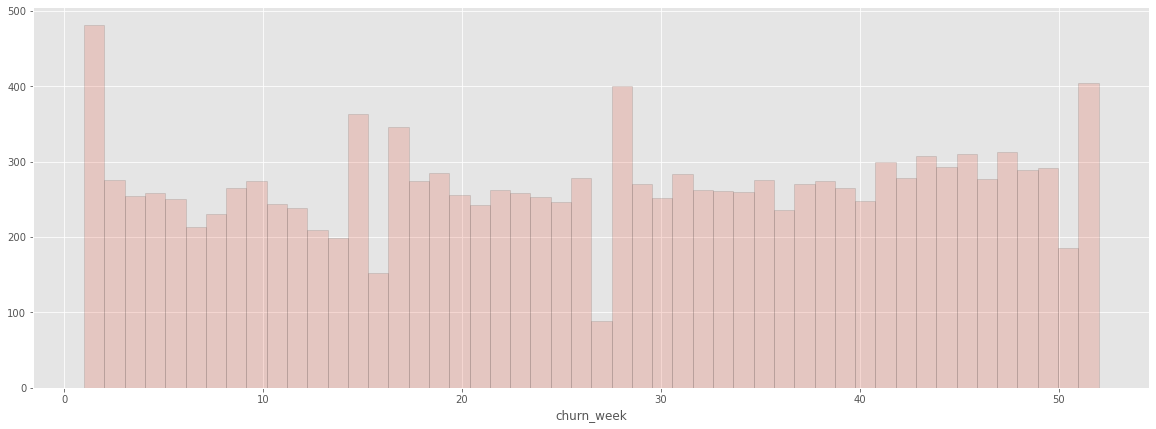

In [198]:
plt.figure(figsize=(20,7))
sns.distplot(data['churn_week'],bins=50, kde=False, hist_kws=hist_kws)

## Modelling

In [148]:
%%time
y = data['quit']
X = data.drop(columns=['quit','employee_id','join_date','quit_date'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1024)
clf = RandomForestClassifier(oob_score=True, random_state=1024)
clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]
print('oob_score : %f ,auc : %f' % (clf.oob_score_,roc_auc_score(y_test, y_pred)))

train_score=clf.score(X_train,y_train)
test_score=clf.score(X_test,y_test)
print(f'train_score: {train_score}, test_score: {test_score}')

oob_score : 0.713172 ,auc : 0.790830
train_score: 0.9998481858205557, test_score: 0.7225258044930176
CPU times: user 2.22 s, sys: 44.9 ms, total: 2.26 s
Wall time: 2.27 s


In [149]:
X.columns

Index(['seniority', 'salary', 'company_id_1', 'company_id_10', 'company_id_11',
       'company_id_12', 'company_id_2', 'company_id_3', 'company_id_4',
       'company_id_5', 'company_id_6', 'company_id_7', 'company_id_8',
       'company_id_9', 'dept_customer_service', 'dept_data_science',
       'dept_design', 'dept_engineer', 'dept_marketing', 'dept_sales',
       'length'],
      dtype='object')

<AxesSubplot:title={'center':'Feature Importance Plot'}, xlabel='importance', ylabel='feature'>

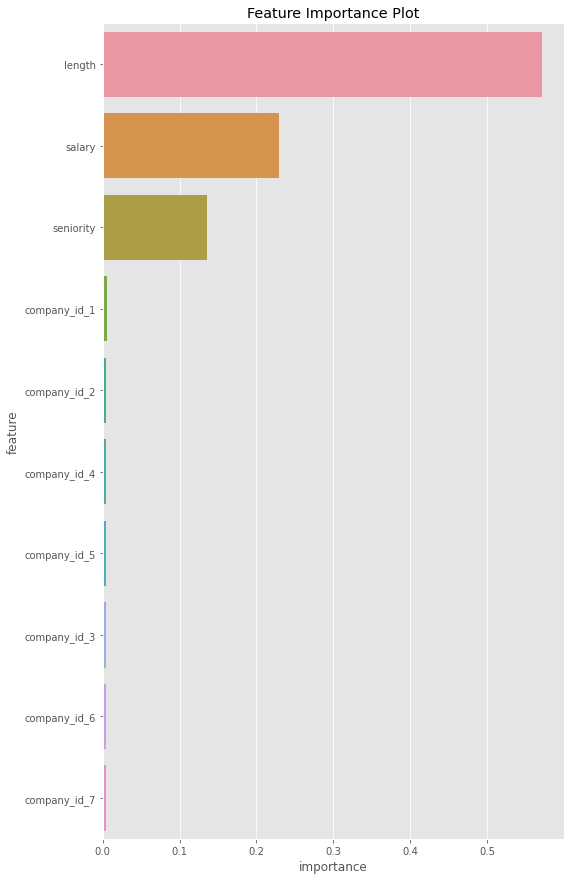

In [151]:
feature_names = X.columns
# Feature importance plot
feature_importance = pd.DataFrame({'feature':feature_names, 'importance':clf.feature_importances_}).sort_values('importance',ascending=False).reset_index().drop(columns='index')
fig, ax = plt.subplots()
fig.set_size_inches(8.27,15)
plt.title('Feature Importance Plot')
sns.barplot(x='importance',y='feature',ax=ax,data=feature_importance[:10])

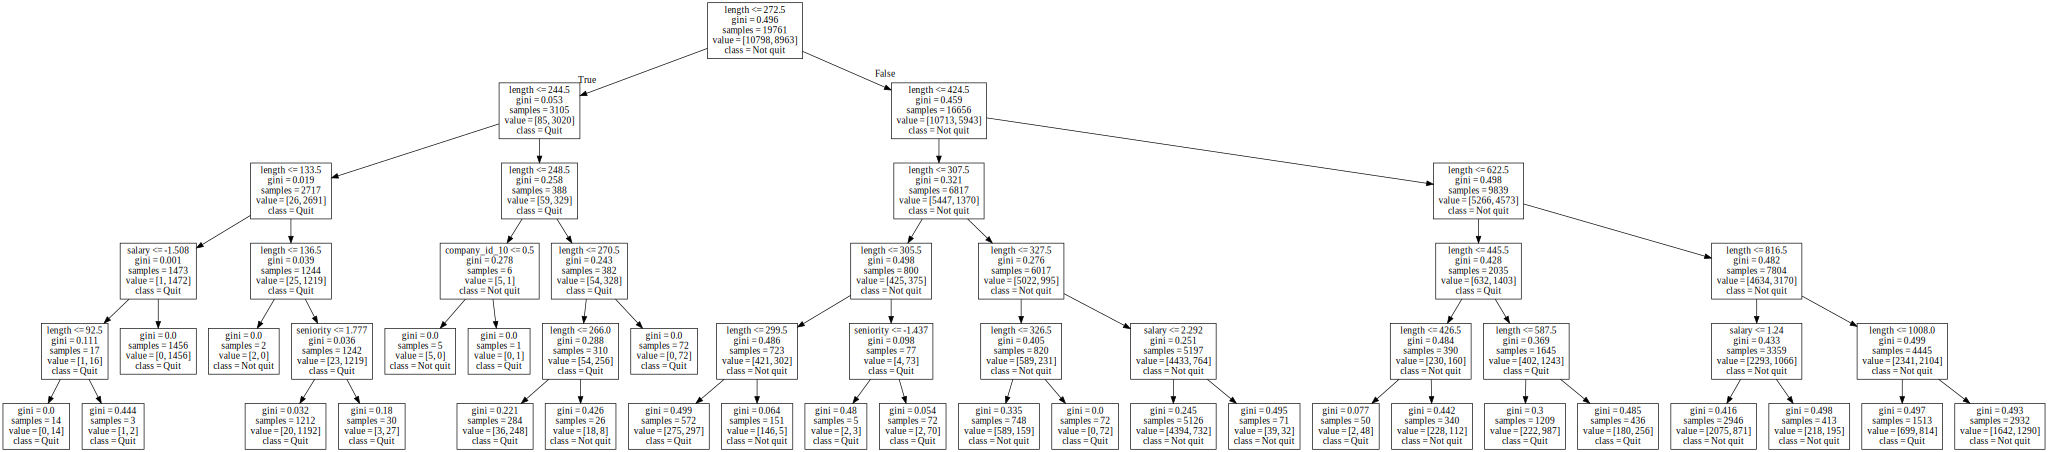

In [200]:
y = data['quit']
X = data.drop(columns=['quit','employee_id','join_date','quit_date','churn_week'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1024)
targets = ['Not quit', 'Quit']
tree_model = DecisionTreeClassifier(random_state=1024, max_depth=3, min_samples_leaf=30).fit(X_train,y_train)
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names, class_names=targets)
graphviz.Source(tree_graph)